Deep Learning using Rectified Linear Units
===

## Overview

In this notebook, we explore the performance of a neural net with varying activation functions on an image classification task.

We load our dependencies.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

__version__ = '1.0.0'
__author__ = 'Abien Fred Agarap'

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

We set up the GPU memory growth.

In [2]:
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

We set the random seeds for reproducibility.

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

We set the batch size, the number of epochs, and the number of units per layer.

In [4]:
batch_size = 512
epochs = 300
neurons = [512, 512]

## Data Preparation

We load the MNIST dataset.

In [5]:
(train_features, train_labels), (test_features, test_labels) = tf.keras.datasets.mnist.load_data()

We scale the images.

In [6]:
train_features = train_features.astype('float32').reshape(-1, 784) / 255.
test_features = test_features.astype('float32').reshape(-1, 784) / 255.

We one-hot encode labels.

In [7]:
train_labels = tf.one_hot(train_labels, 10)
test_labels = tf.one_hot(test_labels, 10)

We create a `tf.data.Dataset` object for the training dataset.

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
dataset = dataset.prefetch(4096).shuffle(4096).batch(batch_size, True)

## Model

We write a `NeuralNet` class that consists of two hidden layers.

In [9]:
class NeuralNet(tf.keras.Model):
    def __init__(self, **kwargs):
        super(NeuralNet, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(
            units=kwargs['units'][0],
            activation=kwargs['activation'],
            kernel_initializer=kwargs['initializer']
        )
        self.hidden_layer_2 = tf.keras.layers.Dense(
            units=kwargs['units'][1],
            activation=kwargs['activation'],
            kernel_initializer=kwargs['initializer']
        )
        self.output_layer = tf.keras.layers.Dense(units=kwargs['num_classes'])
        self.optimizer = tf.optimizers.SGD(learning_rate=3e-4, momentum=9e-1)
    
    @tf.function
    def call(self, features):
        activation = self.hidden_layer_1(features)
        activation = self.hidden_layer_2(activation)
        output = self.output_layer(activation)
        return output

We define our loss function.

In [10]:
def loss_fn(logits, labels):
    softmax_loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    return tf.reduce_mean(softmax_loss)

We define a function for a training step.

In [11]:
def train_step(model, loss, features, labels):
    with tf.GradientTape() as tape:
        logits = model(features)
        train_loss = loss(logits=logits, labels=labels)
    gradients = tape.gradient(train_loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return train_loss

We define a training function.

In [12]:
def train(model, loss_fn, dataset, epochs):
    epoch_accuracy = []
    epoch_loss = []
    for epoch in range(epochs):
        train_accuracy = []
        train_loss = 0
        for batch_features, batch_labels in dataset:
            batch_features += tf.random.normal(stddev=(1. / (1. + epoch)**0.55), shape=batch_features.shape)
            loss = train_step(model, loss_fn, batch_features, batch_labels)
            
            accuracy = tf.metrics.Accuracy()
            predictions = tf.nn.softmax(model(batch_features))
            accuracy(tf.argmax(predictions, 1), tf.argmax(batch_labels, 1))
            
            train_loss += loss
            train_accuracy.append(accuracy.result())
        
        epoch_loss.append(tf.reduce_mean(train_loss))
        epoch_accuracy.append(tf.reduce_mean(train_accuracy))
        
        if (epoch != 0) and ((epoch + 1) % 50 == 0):
            print('epoch {}/{} : mean loss = {}, mean accuracy = {}'.format(epoch + 1,
                                                                            epochs,
                                                                            tf.reduce_mean(train_loss),
                                                                            tf.reduce_mean(train_accuracy)))
    return epoch_accuracy, epoch_loss

### Logistic-based Model

We define a 2-layer NN with Logistic activation function.

In [13]:
model = NeuralNet(
    units=neurons,
    activation=tf.nn.sigmoid,
    initializer='glorot_uniform',
    num_classes=10
)

We train our model for 300 epochs.

In [14]:
logistic_performance = train(model, loss_fn, dataset, epochs=epochs)

epoch 50/300 : mean loss = 219.92889404296875, mean accuracy = 0.6262186169624329
epoch 100/300 : mean loss = 125.63848114013672, mean accuracy = 0.7658587098121643
epoch 150/300 : mean loss = 83.90592193603516, mean accuracy = 0.8242354393005371
epoch 200/300 : mean loss = 65.95451354980469, mean accuracy = 0.8540331125259399
epoch 250/300 : mean loss = 56.727027893066406, mean accuracy = 0.870559573173523
epoch 300/300 : mean loss = 51.20519256591797, mean accuracy = 0.8803919553756714


We produce predictions for the test data.

In [15]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [16]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [17]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.8871999979019165


### TanH-based Model

We define a 2-layer NN with Hyperbolic Tangent activation function.

In [18]:
model = NeuralNet(
    units=neurons,
    activation=tf.nn.tanh,
    initializer='glorot_uniform',
    num_classes=10
)

We train our model for 300 epochs.

In [19]:
tanh_performance = train(model, loss_fn, dataset, epochs=epochs)

epoch 50/300 : mean loss = 41.1085090637207, mean accuracy = 0.8992888331413269
epoch 100/300 : mean loss = 34.88267517089844, mean accuracy = 0.9150474071502686
epoch 150/300 : mean loss = 31.67683982849121, mean accuracy = 0.92311030626297
epoch 200/300 : mean loss = 29.21517562866211, mean accuracy = 0.9298544526100159
epoch 250/300 : mean loss = 27.132604598999023, mean accuracy = 0.9344785213470459
epoch 300/300 : mean loss = 25.023637771606445, mean accuracy = 0.939987301826477


We produce predictions for the test data.

In [20]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [21]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [22]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9387000203132629


### ReLU-based Model

We define a 2-layer NN with ReLU activation function.

In [23]:
model = NeuralNet(
    units=neurons,
    activation=tf.nn.relu,
    initializer='he_normal',
    num_classes=10
)

We train our model for 300 epochs.

In [24]:
relu_performance = train(model, loss_fn, dataset, epochs=epochs)

epoch 50/300 : mean loss = 37.917972564697266, mean accuracy = 0.9058660268783569
epoch 100/300 : mean loss = 28.591215133666992, mean accuracy = 0.9302717447280884
epoch 150/300 : mean loss = 23.436594009399414, mean accuracy = 0.943175733089447
epoch 200/300 : mean loss = 19.79465103149414, mean accuracy = 0.9521400928497314
epoch 250/300 : mean loss = 17.128971099853516, mean accuracy = 0.9587673544883728
epoch 300/300 : mean loss = 15.156322479248047, mean accuracy = 0.9637587070465088


We produce predictions for the test data.

In [25]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [26]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [27]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9607999920845032


### Leaky ReLU-based Model

We define a 2-layer NN with Leaky ReLU activation function.

In [28]:
model = NeuralNet(
    units=neurons,
    activation=tf.nn.leaky_relu,
    initializer='he_normal',
    num_classes=10
)

We train our model for 300 epochs.

In [29]:
lrelu_performance = train(model, loss_fn, dataset, epochs=epochs)

epoch 50/300 : mean loss = 38.26172637939453, mean accuracy = 0.9059996008872986
epoch 100/300 : mean loss = 29.883651733398438, mean accuracy = 0.927200198173523
epoch 150/300 : mean loss = 25.318309783935547, mean accuracy = 0.9388020634651184
epoch 200/300 : mean loss = 22.130830764770508, mean accuracy = 0.9464309811592102
epoch 250/300 : mean loss = 19.446626663208008, mean accuracy = 0.9531416893005371
epoch 300/300 : mean loss = 17.38770294189453, mean accuracy = 0.958650529384613


We produce predictions for the test data.

In [30]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [31]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [32]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9553999900817871


### Softplus-based Model

We define a 2-layer NN with Softplus activation function.

In [33]:
model = NeuralNet(
    units=neurons,
    activation=tf.nn.softplus,
    initializer='he_normal',
    num_classes=10
)

We train our model for 300 epochs.

In [34]:
softplus_performance = train(model, loss_fn, dataset, epochs=epochs)

epoch 50/300 : mean loss = 44.91297149658203, mean accuracy = 0.8903579115867615
epoch 100/300 : mean loss = 37.71559143066406, mean accuracy = 0.9074686169624329
epoch 150/300 : mean loss = 34.804866790771484, mean accuracy = 0.9156650900840759
epoch 200/300 : mean loss = 32.73615264892578, mean accuracy = 0.9212907552719116
epoch 250/300 : mean loss = 31.295867919921875, mean accuracy = 0.9249966740608215
epoch 300/300 : mean loss = 29.9864444732666, mean accuracy = 0.9279513955116272


We produce predictions for the test data.

In [35]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [36]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [37]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9282000064849854


### ELU-based Model

We define a 2-layer NN with ELU activation function.

In [38]:
model = NeuralNet(
    units=neurons,
    activation=tf.nn.elu,
    initializer='he_normal',
    num_classes=10
)

We train our model for 300 epochs.

In [39]:
elu_performance = train(model, loss_fn, dataset, epochs=epochs)

epoch 50/300 : mean loss = 38.46513748168945, mean accuracy = 0.9060162901878357
epoch 100/300 : mean loss = 31.891250610351562, mean accuracy = 0.9221253991127014
epoch 150/300 : mean loss = 27.93938636779785, mean accuracy = 0.9324585795402527
epoch 200/300 : mean loss = 24.76047706604004, mean accuracy = 0.9414229393005371
epoch 250/300 : mean loss = 22.108373641967773, mean accuracy = 0.9475494027137756
epoch 300/300 : mean loss = 19.78851890563965, mean accuracy = 0.9525073170661926


We produce predictions for the test data.

In [40]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [41]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [42]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9502000212669373


## Training Performance

We lay down the training performance of each model.

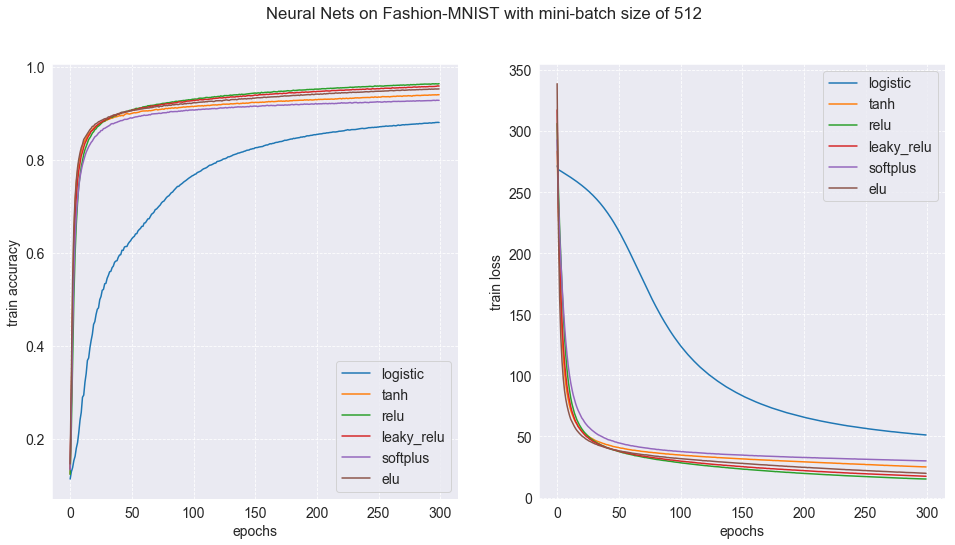

In [43]:
sns.set_style('dark', {'grid.linestyle': '--'})
plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size': 14})

plt.subplot(121)
plt.plot(range(len(logistic_performance[0])), logistic_performance[0], label='logistic')
plt.plot(range(len(tanh_performance[0])), tanh_performance[0], label='tanh')
plt.plot(range(len(relu_performance[0])), relu_performance[0], label='relu')
plt.plot(range(len(lrelu_performance[0])), lrelu_performance[0], label='leaky_relu')
plt.plot(range(len(softplus_performance[0])), softplus_performance[0], label='softplus')
plt.plot(range(len(elu_performance[0])), elu_performance[0], label='elu')
plt.xlabel('epochs')
plt.ylabel('train accuracy')
plt.legend(loc='lower right')
plt.grid()

plt.subplot(122)
plt.plot(range(len(logistic_performance[1])), logistic_performance[1], label='logistic')
plt.plot(range(len(tanh_performance[1])), tanh_performance[1], label='tanh')
plt.plot(range(len(relu_performance[1])), relu_performance[1], label='relu')
plt.plot(range(len(lrelu_performance[1])), lrelu_performance[1], label='leaky_relu')
plt.plot(range(len(softplus_performance[1])), softplus_performance[1], label='softplus')
plt.plot(range(len(elu_performance[1])), elu_performance[1], label='elu')
plt.xlabel('epochs')
plt.ylabel('train loss')
plt.legend(loc='upper right')
plt.grid()

plt.suptitle('Neural Nets on Fashion-MNIST with mini-batch size of 512')
plt.savefig('fmnist_experiments_512.png', dpi=300)
plt.show()